In [1]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import gmaps
import os
import json 
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import urllib
from scipy.stats import linregress
import time

In [2]:
# File to Load
file_to_load = "Resources/BRFSS__Table_of_Overweight_and_Obesity__BMI_.csv"

# Read Obesity CSV and store into Pandas data frame
obesity_df_full = pd.read_csv(file_to_load)
obesity_df_full.head(10)

,Year,Locationabbr,Locationdesc,Class,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,...,Data_Value_Footnote,DataSource,ClassId,TopicId,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
0,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE02,CAT4,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE07,CAT4,_BMI5CAT,RESP042,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,...,NaN,BRFSS,CLASS14,TOPIC09,2,EDUCA2,CAT5,_BMI5CAT,RESP039,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),35-44,Age Group,151,...,NaN,BRFSS,CLASS14,TOPIC09,2,AGE03,CAT3,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME2,CAT6,_BMI5CAT,RESP041,"(64.84507995700051, -147.72205903599973)"
5,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Obese (BMI 30.0 - 99.8),65+,Age Group,261,...,NaN,BRFSS,CLASS14,TOPIC09,2,AGE09,CAT3,_BMI5CAT,RESP039,"(64.84507995700051, -147.72205903599973)"
6,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Less than $15,000",Household Income,49,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME1,CAT6,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
7,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Normal Weight (BMI 18.5-24.9),"$25,000-$34,999",Household Income,48,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME3,CAT6,_BMI5CAT,RESP041,"(64.84507995700051, -147.72205903599973)"
8,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Underweight (BMI 12.0-18.4),"American Indian or Alaskan Native, non-Hispanic",Race/Ethnicity,5,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE03,CAT4,_BMI5CAT,RESP042,"(64.84507995700051, -147.72205903599973)"
9,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Other, non-Hispanic",Race/Ethnicity,19,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE06,CAT4,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"


In [3]:
# Extract Columns that will be used in analysis
reduced_obesity_df = obesity_df_full.loc[:, ["Year", "Locationabbr", "Response", "Break_Out", "Break_Out_Category", 
                                             "Sample_Size", "BreakoutID", "GeoLocation"]]
reduced_obesity_df.head()



,Year,Locationabbr,Response,Break_Out,Break_Out_Category,Sample_Size,BreakoutID,GeoLocation
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,151,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [4]:
# Rename columns for clarity
reduced_obesity_df = reduced_obesity_df.rename(columns={"Locationabbr": "State", 
                                                        "Response": "BMI Range", "Break_Out": "Class", 
                                                        "Break_Out_Category": "Class Category", 
                                                        "Sample_Size": "Number of Respondents",
                                                        "BreakoutID": "Class ID"})

reduced_obesity_df.head()

,Year,State,BMI Range,Class,Class Category,Number of Respondents,Class ID,GeoLocation
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,151,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [5]:
# Reorder columns for clairty
reduced_obesity_df = reduced_obesity_df[['Year', 'State', 'Number of Respondents', 
                                         'BMI Range', 'Class', 'Class Category', 'Class ID', 'GeoLocation']]
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,GeoLocation
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [6]:
# Split GeoLocation into lat and lng for loop
new_column = reduced_obesity_df["GeoLocation"].str.split(",", n = 1, expand = True) 
reduced_obesity_df["Lat"]= new_column[0] 
reduced_obesity_df["Lng"]= new_column[1] 
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,GeoLocation,Lat,Lng
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,"(64.84507995700051, -147.72205903599973)",(64.84507995700051,-147.72205903599973)


In [7]:
# Remove unwanted characters from the Lat and Lng Columns
reduced_obesity_df['Lat'] = reduced_obesity_df['Lat'].str.replace('(', '')
reduced_obesity_df['Lng'] = reduced_obesity_df['Lng'].str.replace(')', '')

In [8]:
# Remove Geolocation
reduced_obesity_df = reduced_obesity_df.drop(columns=['GeoLocation'])

In [9]:
# Remove commas from Number of Respondents
reduced_obesity_df['Number of Respondents'] = reduced_obesity_df['Number of Respondents'].str.replace(',', '')

In [10]:
# Convert Number of Respondents Columns to integer
reduced_obesity_df['Number of Respondents'] = pd.to_numeric(reduced_obesity_df['Number of Respondents'])
reduced_obesity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   47074 non-null  int64 
 1   State                  47074 non-null  object
 2   Number of Respondents  47074 non-null  int64 
 3   BMI Range              47074 non-null  object
 4   Class                  47074 non-null  object
 5   Class Category         47074 non-null  object
 6   Class ID               47074 non-null  object
 7   Lat                    47002 non-null  object
 8   Lng                    47002 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.2+ MB


In [11]:
# Keep only most recent year (2019)
recent_df = reduced_obesity_df.loc[reduced_obesity_df['Year'] == 2019]

In [12]:
# Drop year column
recent_df = recent_df.drop(columns=['Year'])

In [18]:
# Keep only number of Respondents and BMI Range for state v. state comparison
recent_df_reduced = recent_df.loc[:, ["State", "Number of Respondents", "BMI Range"]]
recent_df_reduced[recent_df_reduced['State'] != 'US']

,State,Number of Respondents,BMI Range
0,AK,22,Overweight (BMI 25.0-29.9)
1,AK,2,Underweight (BMI 12.0-18.4)
2,AK,239,Obese (BMI 30.0 - 99.8)
3,AK,151,Overweight (BMI 25.0-29.9)
4,AK,95,Normal Weight (BMI 18.5-24.9)
5,AK,261,Obese (BMI 30.0 - 99.8)
6,AK,49,Overweight (BMI 25.0-29.9)
7,AK,48,Normal Weight (BMI 18.5-24.9)
8,AK,5,Underweight (BMI 12.0-18.4)
9,AK,19,Overweight (BMI 25.0-29.9)


In [14]:
# Display max rows
pd.set_option('display.max_rows', None)

In [15]:
# Display the total number of states
total_states = len(recent_df_reduced["State"].unique())
total_states

54

In [16]:
# Drop the US Rows
drop_us = recent_df_reduced.drop(recent_df_reduced.index[4680:4684])

In [17]:
# Drop the UW Rows
drop_uw = drop_us.drop(recent_df_reduced.index[4788:4792])

In [18]:
# Reset index and Rename DF
clean_state_df = drop_uw.reset_index(drop=True)

In [19]:
# Check new length of states (should be 52, 50 states plus PR and Guam)
new_total_states = len(clean_state_df["State"].unique())
new_total_states

52

In [20]:
# Display the total number of respondents
respondent_total = clean_state_df["Number of Respondents"].sum()
respondent_total

2231286

In [21]:
# Get sum of total respondents for each state
state_sum = clean_state_df.groupby('State')['Number of Respondents'].sum()

# Get sum of total overweight respondents for each state
overweight_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Overweight (BMI 25.0-29.9)'].groupby("State")["Number of Respondents"].sum()

# Find overweight rates for each state
overweight_rates = (overweight_sum / state_sum) * 100

# Get sum of total underweight respondents for each state
underweight_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Underweight (BMI 12.0-18.4)'].groupby("State")["Number of Respondents"].sum()

# Find underweight rates for each state
underweight_rates = (underweight_sum / state_sum) * 100

# Get sum of total obese respondents for each state
obesity_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Obese (BMI 30.0 - 99.8)'].groupby("State")["Number of Respondents"].sum()

# Find obesity rates for each state
obesity_rates = (obesity_sum / state_sum) * 100

# Get sum of total normalweight respondents for each state
normal_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Normal Weight (BMI 18.5-24.9)'].groupby("State")["Number of Respondents"].sum()

# Find Obesity Rates for each state
normal_rates = (normal_sum / state_sum) * 100

In [22]:
# Create New Data Frame to hold the values

state_summary_df = pd.DataFrame({
                                "% Overweight": overweight_rates,
                                "% Underweight": underweight_rates,
                                "% Obese": obesity_rates,
                                "% Normal": normal_rates
                                                        })
state_summary_df.style.format({
                                "% Overweight":"{:,.2f}",
                                "% Underweight": "{:,.2f}",
                                "% Obese": "{:,.2f}",
                                "% Normal": "{:,.2f}"
                                   })

,% Overweight,% Underweight,% Obese,% Normal
State,,,,
AK,36.34,1.56,30.83,31.27
AL,35.22,1.96,35.99,26.84
AR,34.36,1.54,35.27,28.83
AZ,35.95,1.99,30.06,32.00
CA,37.18,1.71,27.05,34.05
CO,36.54,1.89,24.10,37.47
CT,37.97,1.69,28.13,32.21
DC,34.00,1.30,27.35,37.35
DE,35.34,1.67,35.53,27.46


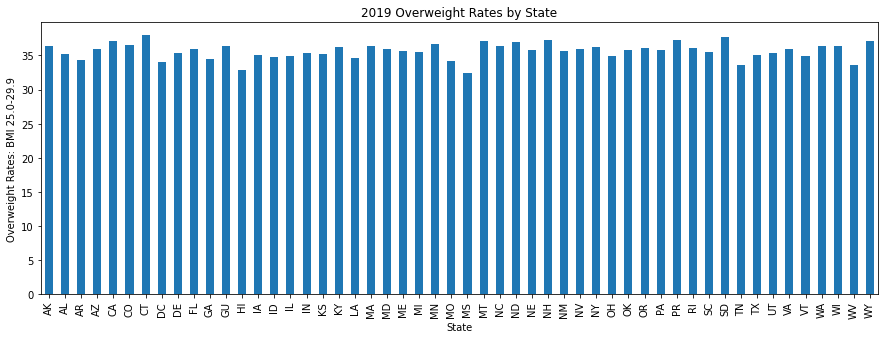

In [29]:
# Create Bar Graph Representing Overweight Rates
x_axis = recent_df_reduced['State'].unique()
y_axis = overweight_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Overweight Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Overweight Rates: BMI 25.0-29.9")
plt.savefig("Output_Data/Fig1.png")

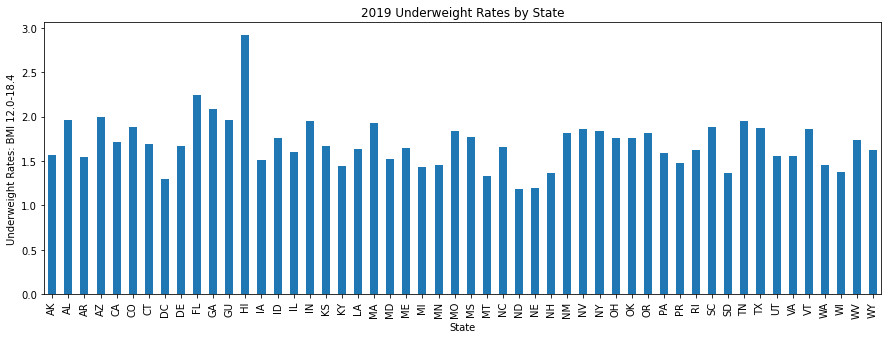

In [30]:
# Create Bar Graph Representing Underweight Rates
x_axis = recent_df_reduced['State'].unique()
y_axis = underweight_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Underweight Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Underweight Rates: BMI 12.0-18.4")
plt.savefig("Output_Data/Fig2.png")

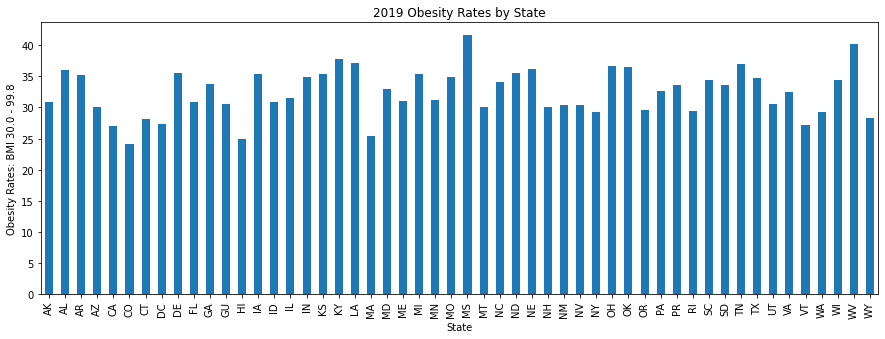

In [31]:
# Create Bar Graph Representing Obesity Rates
x_axis = recent_df_reduced['State'].unique()
y_axis = obesity_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Obesity Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Obesity Rates: BMI 30.0 - 99.8")
plt.savefig("Output_Data/Fig3.png")

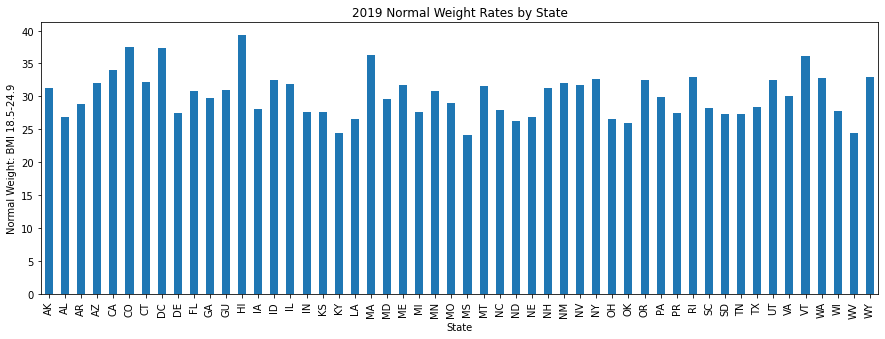

In [32]:
# Create Bar Graph Representing Normal Rates
x_axis = recent_df_reduced['State'].unique()
y_axis = normal_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Normal Weight Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Normal Weight: BMI 18.5-24.9")
plt.savefig("Output_Data/Fig4.png")

In [35]:
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,Lat,Lng
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,64.84507995700051,-147.72205903599973
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,64.84507995700051,-147.72205903599973
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,64.84507995700051,-147.72205903599973
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,64.84507995700051,-147.72205903599973
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,64.84507995700051,-147.72205903599973


In [36]:
# Keep only Maryland data
md_df = reduced_obesity_df.loc[reduced_obesity_df['State'] == 'MD']

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,Lat,Lng
2184,2019,MD,23,Underweight (BMI 12.0-18.4),Less than H.S.,Education Attained,EDUCA1,39.29058096400047,-76.60926011099963
2185,2019,MD,18,Underweight (BMI 12.0-18.4),"Less than $15,000",Household Income,INCOME1,39.29058096400047,-76.60926011099963
2186,2019,MD,2446,Normal Weight (BMI 18.5-24.9),College graduate,Education Attained,EDUCA4,39.29058096400047,-76.60926011099963
2187,2019,MD,317,Obese (BMI 30.0 - 99.8),Less than H.S.,Education Attained,EDUCA1,39.29058096400047,-76.60926011099963
2188,2019,MD,3186,Overweight (BMI 25.0-29.9),"$50,000+",Household Income,INCOME5,39.29058096400047,-76.60926011099963


In [41]:
# Drop state, lat, and lng columns
md_df_reduced = md_df.drop(columns=['State', 'Lat', 'Lng'])

In [65]:
md_df_reduced['Number of Respondents'] = md_df_reduced['BMI Range'].str.replace('bmi', 'BMI')

In [66]:
# Reset index and Rename DF
md_clean_df = md_df_reduced.reset_index(drop=True)
md_clean_df

,Year,Number of Respondents,BMI Range,Class,Class Category,Class ID
0,2019,Underweight (BMI 12.0-18.4),Underweight (BMI 12.0-18.4),Less than H.S.,Education Attained,EDUCA1
1,2019,Underweight (BMI 12.0-18.4),Underweight (BMI 12.0-18.4),"Less than $15,000",Household Income,INCOME1
2,2019,Normal Weight (BMI 18.5-24.9),Normal Weight (BMI 18.5-24.9),College graduate,Education Attained,EDUCA4
3,2019,Obese (BMI 30.0 - 99.8),Obese (BMI 30.0 - 99.8),Less than H.S.,Education Attained,EDUCA1
4,2019,Overweight (BMI 25.0-29.9),Overweight (BMI 25.0-29.9),"$50,000+",Household Income,INCOME5
5,2019,Normal Weight (BMI 18.5-24.9),Normal Weight (BMI 18.5-24.9),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07
6,2019,Normal Weight (BMI 18.5-24.9),Normal Weight (BMI 18.5-24.9),"White, non-Hispanic",Race/Ethnicity,RACE01
7,2019,Obese (BMI 30.0 - 99.8),Obese (BMI 30.0 - 99.8),55-64,Age Group,AGE05
8,2019,Overweight (BMI 25.0-29.9),Overweight (BMI 25.0-29.9),18-24,Age Group,AGE01
9,2019,Overweight (BMI 25.0-29.9),Overweight (BMI 25.0-29.9),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07


In [67]:
# Get sum of total respondents for each year
md_year_sum = md_clean_df.groupby('Year')['Number of Respondents'].sum()
md_year_sum 

Year
2011    Obese (BMI 30.0 - 99.8)Overweight (BMI 25.0-29...
2012    Underweight (BMI 12.0-18.4)Normal Weight (BMI ...
2013    Obese (BMI 30.0 - 99.8)Overweight (BMI 25.0-29...
2014    Underweight (BMI 12.0-18.4)Normal Weight (BMI ...
2015    Obese (BMI 30.0 - 99.8)Underweight (BMI 12.0-1...
2016    Underweight (BMI 12.0-18.4)Overweight (BMI 25....
2017    Normal Weight (BMI 18.5-24.9)Obese (BMI 30.0 -...
2018    Normal Weight (BMI 18.5-24.9)Underweight (BMI ...
2019    Underweight (BMI 12.0-18.4)Underweight (BMI 12...
Name: Number of Respondents, dtype: object

In [68]:
# Get sum of obese respondents for each year
md_obesity_sum_pt1 = md_clean_df.loc[md_clean_df["BMI Range"] == 
'Obese (BMI 30.0 - 99.8)'.groupby("Year")["Number of Respondents"].sum()

SyntaxError: unexpected EOF while parsing (<ipython-input-68-5b637b71cd67>, line 3)

In [61]:
md_obesity_sum_pt1

Year
2011    15516
2012    20512
2013    21197
2014    20997
2018    30049
2019    30494
Name: Number of Respondents, dtype: int64

In [62]:
md_obesity_sum_pt2

Year
2015    20163
2016    31288
2017    23252
Name: Number of Respondents, dtype: int64

In [57]:
md_obesity

Year
2011   NaN
2012   NaN
2013   NaN
2014   NaN
2015   NaN
2016   NaN
2017   NaN
2018   NaN
2019   NaN
Name: Number of Respondents, dtype: float64